# Question Response Time on Stack Overflow

## Project Overview

Stack Overflow is a community-based space for finding and contributing answers to technical challenges. Given a newly posted question on Stack Overflow, how long will it take to receive the first answer? Are response times related to factors in how the question is asked by the questioner? If so, what are those factors?

In this project, I analyze a wide range of features that cover many facets of the data and identify those that correlate with question response time and use them to build prediction models through simple database queries and machine learning techniques.

## BigQuery Setup and Dependencies

In [ ]:
# Authenticate to Bigquery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-project2-tg"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Use Matplotlib to create visualizations
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Analysis of Dataset

**Dataset Source**

I plan to use a BigQuery Public Dataset. The name of the dataset is listed below:

- `bigquery-public-data.stackoverflow`

**How the dataset is organised?**

Updated on a quarterly basis, this BigQuery dataset includes an archive of Stack Overflow content, including posts, comments, users, tags, votes, and badges.

The dataset has 16 tables with total logical bytes of hundreds of Gigabytes. I am using three tables for this project, listed as follows:

- `bigquery-public-data.stackoverflow.users`: It contains information for each Stack Overflow user, including their user id, creation date, last access date, reputation. The `id` is a primary key, a unique integer we use to refer to a user. `creation_date` is the date when a user account is created, which will be used for exploration in the next section.

- `bigquery-public-data.stackoverflow.posts_questions`: It contains information for all Stack Overflow questions, including question id, question title, question body, accepted answer id (if answered), answer count, creation date, score, tags, view count and owner user id. The `id` is a primary key, a unique integer we use to refer to a question. The `owner_user_id` is a foreign key. That is, every `owner user id` in this table refers to an `id` in the `bigquery-public-data.stackoverflow.users`. Other keys that will be used for exploration in the next section: `title`, `body`, `creation_date`, `tags`.

- `bigquery-public-data.stackoverflow.posts_answers`: It contains information for each of the answers to above questions, such as answer id, answer body, creation date, score, owner user id, and parent id. The `id` is a primary key, a unique integer we use to refer to an answer. The `parent_id` is a foreign key which links back to an `id` in the `bigquery-public-data.stackoverflow.posts_questions`. `creation_date` is the date when an answer is created, which will be used for exploration in the next section.

**How many questions were posted on Stack Overflow over the years, and what percentage of them have been answered?**

In [ ]:
%%bigquery questions_overview --project $project_id

SELECT
  year,
  COUNT(*) AS num_question,
  COUNTIF(answer_count > 0) AS num_question_answered,
  ROUND(100 * COUNTIF(answer_count > 0) / COUNT(*), 2) AS percent_question_answered
FROM (
  SELECT
    EXTRACT(YEAR FROM creation_date) AS year,
    answer_count
  FROM
    `bigquery-public-data.stackoverflow.posts_questions`
)
GROUP BY
  year
ORDER BY
  year

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
questions_overview

,year,num_question,num_question_answered,percent_question_answered
0,2008,57569,57495,99.87
1,2009,341651,340436,99.64
2,2010,690840,684254,99.05
3,2011,1189881,1161031,97.58
4,2012,1629386,1549529,95.10
5,2013,2033690,1879399,92.41
6,2014,2137435,1908588,89.29
7,2015,2196676,1912123,87.05
8,2016,2200802,1878653,85.36
9,2017,2116212,1774813,83.87


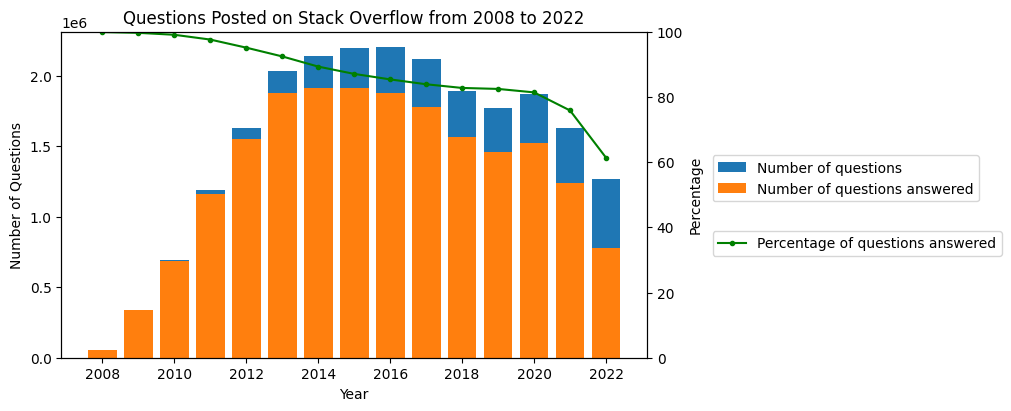

In [ ]:
  fig, ax = plt.subplots(figsize=(10, 4), layout='constrained')
  ax.bar(questions_overview.year, questions_overview.num_question, label = "Number of questions")
  ax.bar(questions_overview.year, questions_overview.num_question_answered, label = "Number of questions answered")
  ax.set_xlabel('Year')
  ax.set_ylabel('Number of Questions')
  ax.set_title('Questions Posted on Stack Overflow from 2008 to 2022')
  ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.55))

  ax2 = ax.twinx()
  ax2.set_ylabel('Percentage')
  ax2.set_ylim(0, 100)
  ax2.plot(questions_overview.year, questions_overview.percent_question_answered,
           color = 'g', marker = '.', label = "Percentage of questions answered")
  ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.35))

The graph shows data on questions posted on Stack Overflow from 2008 to 2022 (2022 only includes data from January to September).

The total number of questions asked on the platform has generally increased over the years, with some fluctuations. There is a notable rise from 2008 to 2014, a plateau from around 2014 to 2018, and a slight decline from 2018 onwards.

The number of questions answered follows a similar trend, increasing up until 2014, then plateauing, and finally declining slightly after 2018.

The line graph shows a high percentage of questions with answers in 2008, which then decreases annually. This trend suggests that while Stack Overflow has seen a significant increase in activity over the years, the proportion of questions that receive answers has declined, possibly due to the sheer volume of questions outpacing the community's ability to provide answers.

We are having a large amount of data spanning multiple years. In the next two sections of data exploration and prediction, I will sample a subset of data across all months **from 2021 to 2022** from such a large dataset to effectively reduce the size of the dataset to a more manageable level.


Create a dataset `subsets_stackoverflow` in BigQuery to store the subsets of questions and answers.

In [ ]:
  dataset_name = 'subsets_stackoverflow'

  dataset = bigquery.Dataset(client.dataset(dataset_name))
  dataset.location = 'US'
  client.create_dataset(dataset)

Use `CREATE TABLE` to save the subsets in BigQuery.

In [ ]:
%%bigquery --project $project_id

CREATE TABLE IF NOT EXISTS `subsets_stackoverflow.questions` AS
SELECT
  *
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  EXTRACT(DATE FROM creation_date) >= '2021-01-01'

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

CREATE TABLE IF NOT EXISTS `subsets_stackoverflow.answers` AS
SELECT
  *
FROM
  `bigquery-public-data.stackoverflow.posts_answers`
WHERE parent_id IN (SELECT id FROM `subsets_stackoverflow.questions`)

Query is running:   0%|          |

""


**Overall Size and Complexity**

- `subsets_stackoverflow.questions` (5.39 GB): Extract questions from 2021 to 2022 from `bigquery-public-data.stackoverflow.posts_questions`. There are 2,898,368 entries (questions) in this table.

- `subsets_stackoverflow.answers` (2.82 GB): Extract data from `bigquery-public-data.stackoverflow.posts_answers` for each of the answers to above questions. There are 2,730,242 entries (answers) in this table.

- `bigquery-public-data.stackoverflow.users` (3.14 GB): There are 18,712,212 entries (users) in this table.

Total Dataset Size: 11.35 GB

**NULL Values**

In [ ]:
%%bigquery --project $project_id

SELECT
  COUNTIF(owner_user_id IS NULL) AS null_user,
  ROUND(100 * COUNTIF(owner_user_id IS NULL) / COUNT(*), 2) AS percent_null_user,
  COUNTIF(title IS NULL) AS null_title,
  ROUND(100 * COUNTIF(title IS NULL) / COUNT(*), 2) AS percent_null_title,
  COUNTIF(body IS NULL) AS null_body,
  ROUND(100 * COUNTIF(body IS NULL) / COUNT(*), 2) AS percent_body,
  COUNTIF(creation_date IS NULL) AS null_creation_date,
  ROUND(100 * COUNTIF(creation_date IS NULL) / COUNT(*), 2) AS percent_null_creation_date,
  COUNTIF(tags IS NULL) AS null_tags,
  ROUND(100 * COUNTIF(tags IS NULL) / COUNT(*), 2) AS percent_null_tags,
FROM
  `subsets_stackoverflow.questions`

Query is running:   0%|          |

Downloading:   0%|          |

,null_user,percent_null_user,null_title,percent_null_title,null_body,percent_body,null_creation_date,percent_null_creation_date,null_tags,percent_null_tags
0,36885,1.27,0,0.0,0,0.0,0,0.0,0,0.0


In [ ]:
%%bigquery --project $project_id

SELECT
  COUNTIF(parent_id IS NULL) AS null_parent_id,
  ROUND(100 * COUNTIF(parent_id IS NULL) / COUNT(*), 2) AS percent_null_parent_id,
  COUNTIF(creation_date IS NULL) AS null_creation_date,
  ROUND(100 * COUNTIF(creation_date IS NULL) / COUNT(*), 2) AS percent_null_creation_date,
FROM
  `subsets_stackoverflow.answers`

Query is running:   0%|          |

Downloading:   0%|          |

,null_parent_id,percent_null_parent_id,null_creation_date,percent_null_creation_date
0,0,0.0,0,0.0


In [ ]:
%%bigquery --project $project_id

SELECT
  COUNTIF(creation_date IS NULL) AS null_creation_date,
  ROUND(100 * COUNTIF(creation_date IS NULL) / COUNT(*), 2) AS percent_null_creation_date,
FROM
  `bigquery-public-data.stackoverflow.users`

Query is running:   0%|          |

Downloading:   0%|          |

,null_creation_date,percent_null_creation_date
0,0,0.0


36885 questions have a value of null for their `owner_user_id`, with a percentage of 1.27%, and we will filter them out before exploration.

There are no null values in columns that will be used for exploration in answers or users table.

**Data Splits**

We will also separate the data into 3 different datasets to train, evaluate, and finally test the model:

* **Training dataset** (80%): question creation date between '2021-01-01' and '2022-05-31'

* **Validation dataset** (10%): question creation date between '2022-06-01' and '2022-07-31'

* **Test dataset** (10%): question creation date between '2022-08-01' and '2022-09-15'

In the next part of investigating correlations between attributes, We will only visualize the **training data**.

## Data Exploration

Create a dataset `features_stackoverflow` in BigQuery to store the intermediate results so that we don't have to run the same query multiple times.

In [ ]:
  dataset_name = 'features_stackoverflow'

  dataset = bigquery.Dataset(client.dataset(dataset_name))
  dataset.location = 'US'
  client.create_dataset(dataset)

### Preprocessing

After filtering out questions that have a value of null for their `owner_user_id`, we want to evaluate the time taken by a question to be answered, so for this purpose, we merge our two tables `subsets_stackoverflow.questions` and `subsets_stackoverflow.answers`, and select columns that will be used for exploration. After merging, we subtract the question creation time and the first answer creation time and calculate the difference in minutes. We add one more attribute `time_to_first_answer`, which contains information of that calculated difference. If a question does not receive any answer, `time_to_first_answer` has a value of null.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `features_stackoverflow.time_to_first_answer` AS
  SELECT
    questions.id AS question_id,
    questions.title AS question_title,
    questions.body AS question_body,
    questions.owner_user_id AS owner_user_id,
    questions.tags AS question_tags,
    questions.creation_date AS question_creation_date,
    first_answers.id AS first_answer_id,
    first_answers.creation_date AS first_answer_creation_date,
    TIMESTAMP_DIFF(first_answers.creation_date,questions.creation_date, MINUTE) AS time_to_first_answer
  FROM
    `subsets_stackoverflow.questions` questions
  LEFT JOIN (
    SELECT
      id,
      parent_id,
      creation_date
    FROM (
      SELECT
        id,
        parent_id,
        creation_date,
        RANK() OVER (PARTITION BY parent_id ORDER BY creation_date) AS rank
      FROM
        `subsets_stackoverflow.answers` )
    WHERE
      rank = 1) first_answers
  ON
    questions.id = first_answers.parent_id
  WHERE
    questions.owner_user_id IS NOT NULL

Query is running:   0%|          |

""


**How long does it take to get an answer?**

In [ ]:
%%bigquery --project $project_id

SELECT
  ROUND(100 * COUNT(time_to_first_answer) / COUNT(*), 2) AS percent_question_answered,
  ROUND(AVG(time_to_first_answer)) AS avg_time,
  ROUND(STDDEV(time_to_first_answer)) AS std
FROM
  `features_stackoverflow.time_to_first_answer`
WHERE
  EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-5-31'
  AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)

Query is running:   0%|          |

Downloading:   0%|          |

,percent_question_answered,avg_time,std
0,71.81,10809.0,55844.0


The average time shows that we have to wait for days before getting a reply on Stack Overflow, which doesn’t reflect our normal experience. This is because there are some questions take over years to get the answer, creating a strong bias towards a long time.

To reduce the impact of outliers, we can calculate the median time instead.

In [ ]:
%%bigquery --project $project_id

SELECT
  APPROX_QUANTILES(time_to_first_answer, 100)[SAFE_OFFSET(50)] AS median_time,
FROM
  `features_stackoverflow.time_to_first_answer`
WHERE
  EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
  AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)

Query is running:   0%|          |

Downloading:   0%|          |

,median_time
0,62


The NULL values are excluded from the result, and the median time to receive an answer is 62 minutes, which sounds like the more sensible number.

In [ ]:
%%bigquery percent_response_time --project $project_id

SELECT
  percent_within_1_hour,
  percent_within_1_day,
  100 - percent_within_1_hour - percent_within_1_day AS percent_more_than__1_day
FROM (
  SELECT
    100 * COUNTIF(time_to_first_answer BETWEEN 0 AND 60) / COUNT(*) AS percent_within_1_hour,
    100 * COUNTIF(time_to_first_answer BETWEEN 61 AND 1440) / COUNT(*) AS percent_within_1_day
  FROM
    `features_stackoverflow.time_to_first_answer`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))

Query is running:   0%|          |

Downloading:   0%|          |

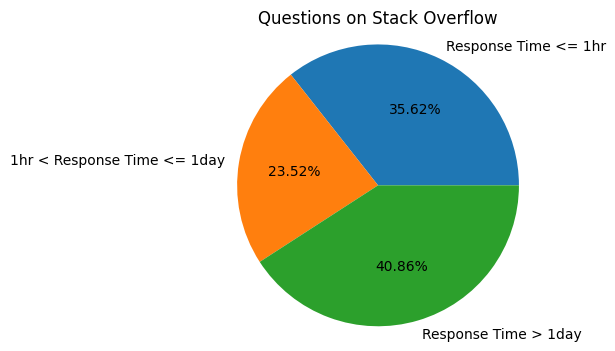

In [ ]:
import pandas as pd

df = pd.DataFrame({'data': [percent_response_time.percent_within_1_hour, percent_response_time.percent_within_1_day, percent_response_time.percent_more_than__1_day],
                   'labels': ['Response Time <= 1hr', '1hr < Response Time <= 1day', 'Response Time > 1day']})
plt.figure(figsize=(4, 4))
plt.pie(df['data'], labels=df['labels'], autopct='%.2f%%')
plt.axis('equal')
plt.title('Questions on Stack Overflow')
plt.show()

More than one-third of questions were answered within an hour, and approximately 40% were not answered within a day (including those that did not receive any answer).

To analyze the features and their correlation with response time, we constructed box plots (feature value vs. response time) that capture the median, 25% and 75% of the distributions, as well as the minimum and maximum values. There are outliers (shown as circles), indicating instances of particularly long response times.

### Post Date

#### Day of Week
In this query, we extract day of week from timestamp.

In [ ]:
%%bigquery day_of_week --project $project_id

SELECT
  question_day,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    EXTRACT(DAYOFWEEK from question_creation_date) as question_day,
    time_to_first_answer
  FROM
    `features_stackoverflow.time_to_first_answer`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  question_day
ORDER BY
  question_day

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  day_of_week

,question_day,num_questions_answered,quantile_response_time
0,1,223214,"[0, 15, 63, 579, 896551]"
1,2,360021,"[0, 14, 61, 605, 901800]"
2,3,387969,"[0, 14, 61, 620, 891385]"
3,4,392576,"[0, 14, 59, 580, 899423]"
4,5,387747,"[0, 14, 62, 651, 900516]"
5,6,350133,"[0, 15, 63, 729, 904060]"
6,7,217693,"[0, 16, 65, 637, 865341]"


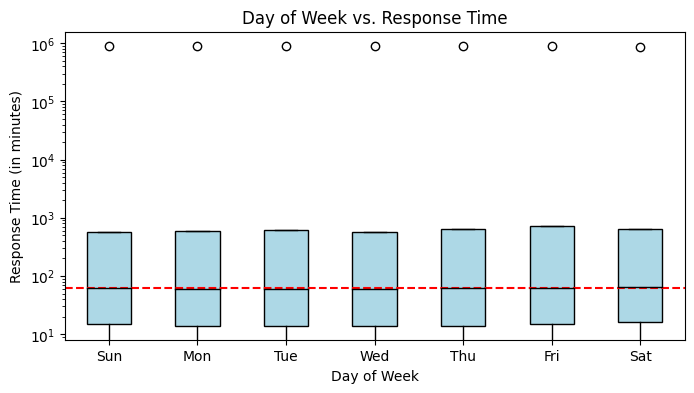

In [ ]:
  plt.figure(figsize=(8, 4))
  label = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
  plt.boxplot(day_of_week.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=label)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Day of Week")
  plt.ylabel("Response Time (in minutes)")
  plt.title("Day of Week vs. Response Time")
  plt.yscale("log")

The query returns day of the week as integers from 1 to 7 (1 = Sunday, 2 = Monday, etc), the number of questions answered per day and the approximate quantile boundaries.

The number of questions answered is the highest in the middle of the week (Tue, Wed, and Thu). Questions are answered faster  on weekdays. Compared with weekdays, response times on Saturdays and Sundays are longer, although the difference is not that significant, and the median values are basically around 62 minutes. Therefore, the day on which questions are asked may provide weak evidence for estimating response time.

#### Hour of Day
In this query, we extract the hour of the day from timestamp.

In [ ]:
%%bigquery hour_of_day --project $project_id

SELECT
  question_hour,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    EXTRACT(HOUR from question_creation_date) as question_hour,
    time_to_first_answer
  FROM
    `features_stackoverflow.time_to_first_answer`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  question_hour
ORDER BY
  question_hour

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  hour_of_day

,question_hour,num_questions_answered,quantile_response_time
0,0,52013,"[0, 19, 93, 655, 899423]"
1,1,50042,"[0, 19, 90, 591, 833664]"
2,2,52491,"[0, 19, 90, 584, 856335]"
3,3,54690,"[0, 18, 85, 520, 866061]"
4,4,57780,"[0, 17, 74, 478, 852727]"
5,5,66062,"[0, 16, 67, 465, 858733]"
6,6,81543,"[0, 14, 57, 414, 873034]"
7,7,98073,"[0, 14, 58, 470, 872266]"
8,8,110370,"[0, 14, 55, 482, 891385]"
9,9,122997,"[0, 14, 61, 495, 877984]"


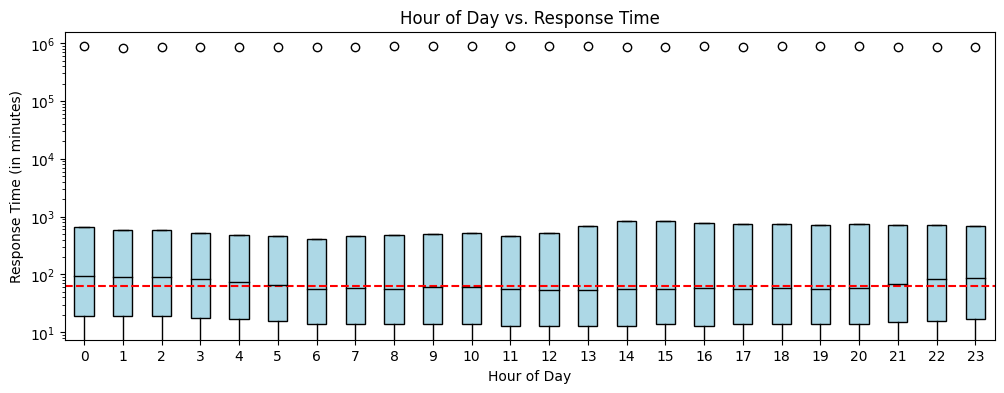

In [ ]:
  plt.figure(figsize = (12, 4))
  plt.boxplot(hour_of_day.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=hour_of_day.question_hour)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Hour of Day")
  plt.ylabel("Response Time (in minutes)")
  plt.title("Hour of Day vs. Response Time")
  plt.yscale("log")

The plot indicates a cyclic trend across the hours of the day. The response times during early hours (0-5) and night hours (21-23) tend to be longer compared to the daytime hours while the number of questions answered is less, which suggests that  the likelihood of getting an answer and the response time may be influenced by the time of day.

### Tags

Tags are a means of connecting experts with questions they will be able to answer by sorting questions into specific, well-defined categories.

#### Number of Tags

`tags` have names of technologies separated by the delimiter "|". There is a limit of 5 tags for a posted question. We can extract the tag for each question and count the number of tags each question contains.

In [ ]:
%%bigquery num_tags --project $project_id

SELECT
  num_tags,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    question_id,
    time_to_first_answer,
    ARRAY_LENGTH(SPLIT(question_tags,'|')) AS num_tags
  FROM
    `features_stackoverflow.time_to_first_answer`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  num_tags
ORDER BY
  num_tags

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  num_tags

,num_tags,num_questions_answered,quantile_response_time
0,1,273073,"[0, 10, 36, 296, 867888]"
1,2,583888,"[0, 12, 46, 385, 901800]"
2,3,644101,"[0, 15, 62, 624, 904060]"
3,4,457402,"[0, 18, 85, 916, 900516]"
4,5,360889,"[0, 21, 110, 1144, 896551]"


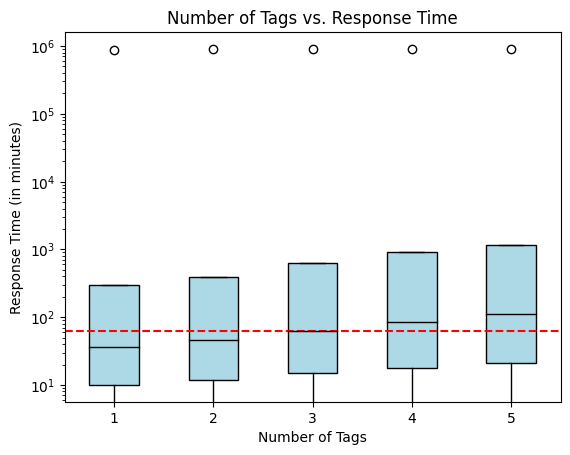

In [ ]:
  plt.boxplot(num_tags.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=num_tags.num_tags)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Number of Tags")
  plt.ylabel("Response Time (in minutes)")
  plt.title("Number of Tags vs. Response Time")
  plt.yscale("log")

We can see that as the number of tags increases, the response time increases. One or two seems to be plenty for most questions, more tags may mean more complex topics that may take longer to receive a reply because they require specific expertise.

#### Average Popularity

Let's define popularity of a tag *t* as its frequency, i.e., the number of questions that contains *t* as one of its tags. For each question, we then compute the average popularity of all its tags.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `subsets_stackoverflow.tags` AS
SELECT
  tag_name,
  COUNT(*) AS tag_count
FROM (
  SELECT
    question_id,
    tag_name
  FROM (
    SELECT
      question_id,
      SPLIT(question_tags,'|') AS question_tags,
    FROM
      `features_stackoverflow.time_to_first_answer`)
  CROSS JOIN
    UNNEST(question_tags) tag_name)
GROUP BY
  tag_name

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `features_stackoverflow.avg_tag_popularity` AS
WITH avg_tag_popularity AS (
  SELECT
    questions_tags.question_id,
    ROUND(AVG(tags.tag_count)) AS avg_tag_popularity
  FROM (
    SELECT
      question_id,
      question_tag
    FROM (
      SELECT
        question_id,
        SPLIT(question_tags,'|') AS question_tags,
      FROM
        `features_stackoverflow.time_to_first_answer`)
    CROSS JOIN
      UNNEST(question_tags) question_tag) questions_tags
  LEFT JOIN
    `subsets_stackoverflow.tags` tags
  ON
    questions_tags.question_tag = tags.tag_name
  GROUP BY
    questions_tags.question_id)

SELECT
  questions.*,
  ARRAY_LENGTH(SPLIT(questions.question_tags,'|')) AS num_tags,
  avg_tag_popularity.avg_tag_popularity
FROM
  `features_stackoverflow.time_to_first_answer` questions
LEFT JOIN
  avg_tag_popularity
ON
  questions.question_id = avg_tag_popularity.question_id

Query is running:   0%|          |

""


In [ ]:
%%bigquery avg_tag_popularity --project $project_id

SELECT
  log_avg_tag_popularity,
  CONCAT("2^",log_avg_tag_popularity, "-", "2^",log_avg_tag_popularity+1) AS avg_tag_popularity_label,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    question_id,
    time_to_first_answer,
    FLOOR(LOG(avg_tag_popularity, 2)) AS log_avg_tag_popularity
  FROM
    `features_stackoverflow.avg_tag_popularity`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  log_avg_tag_popularity
ORDER BY
  log_avg_tag_popularity

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  avg_tag_popularity

,log_avg_tag_popularity,avg_tag_popularity_label,num_questions_answered,quantile_response_time
0,0.0,2^0-2^1,154,"[0, 74, 1373, 12341, 579013]"
1,1.0,2^1-2^2,430,"[0, 150, 1399, 17288, 701328]"
2,2.0,2^2-2^3,1050,"[0, 176, 1370, 13195, 763665]"
3,3.0,2^3-2^4,2071,"[0, 202, 1569, 17218, 590736]"
4,4.0,2^4-2^5,4072,"[0, 246, 1700, 16054, 848633]"
5,5.0,2^5-2^6,7636,"[0, 195, 1448, 11809, 756949]"
6,6.0,2^6-2^7,13450,"[0, 162, 1192, 8362, 850097]"
7,7.0,2^7-2^8,21840,"[0, 122, 1012, 6708, 842513]"
8,8.0,2^8-2^9,37227,"[0, 107, 755, 4489, 871218]"
9,9.0,2^9-2^10,53679,"[0, 78, 522, 3266, 891385]"


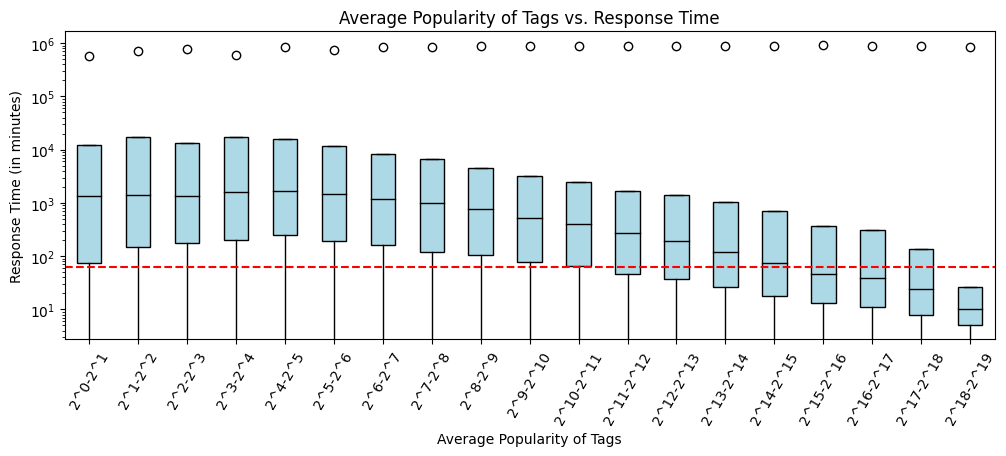

In [ ]:
  plt.figure(figsize = (12, 4))
  plt.boxplot(avg_tag_popularity.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=avg_tag_popularity.avg_tag_popularity_label)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Average Popularity of Tags")
  plt.ylabel("Response Time (in minutes)")
  plt.title("Average Popularity of Tags vs. Response Time")
  plt.xticks(rotation = 60)
  plt.yscale("log")

We can see that as the average popularity of tags increases the response time decreases significantly, which implies that using more popular tags in a question is likely to result in an earlier answer on average.

### Title

#### Question Word

This query returns a column called "question_word". The "question_word" value is 1 if the question title starts with "wh" or "how", and 0 otherwise.

In [ ]:
%%bigquery question_word --project $project_id

SELECT
  question_word,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    CASE
      WHEN LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%' THEN 1
      ELSE 0
    END AS question_word,
    time_to_first_answer
  FROM
    `features_stackoverflow.avg_tag_popularity`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  question_word
ORDER BY
  question_word DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  question_word

,question_word,num_questions_answered,quantile_response_time
0,1,610668,"[0, 13, 49, 416, 887946]"
1,0,1708685,"[0, 15, 68, 753, 904060]"


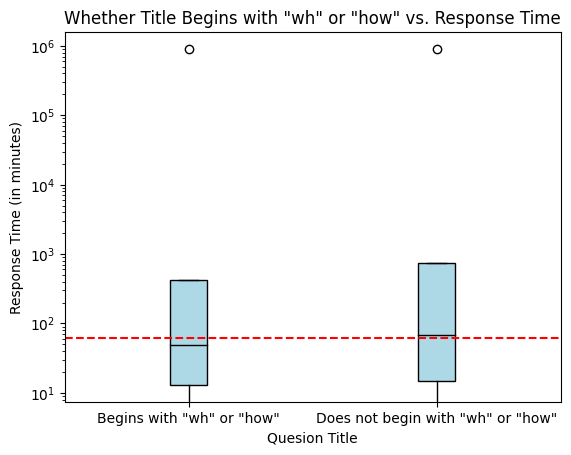

In [ ]:
  label = ['Begins with "wh" or "how"', 'Does not begin with "wh" or "how"']
  plt.boxplot(question_word.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels = label)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Quesion Title")
  plt.ylabel("Response Time (in minutes)")
  plt.title('Whether Title Begins with "wh" or "how" vs. Response Time')
  plt.yscale("log")

We can see that questions  start with “wh” or "how" words in their title are more likely to receive faster responses. The trend indicates that clearly stated questions with sufficient details using question words like who (for people), what/which (for things), when (for time), where (for places), why (for reasons) and how (for more details) might receive responses quicker.

#### Question Mark

This query returns a column called "question_mark". The "question_mark" value is 1 if title ends with a question mark, and 0 otherwise.

In [ ]:
%%bigquery question_mark --project $project_id

SELECT
  question_mark,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    CASE
      WHEN question_title LIKE '%?' THEN 1
      ELSE 0
    END AS question_mark,
    time_to_first_answer
  FROM
    `features_stackoverflow.avg_tag_popularity`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  question_mark
ORDER BY
  question_mark DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  question_mark

,question_mark,num_questions_answered,quantile_response_time
0,1,533783,"[0, 13, 53, 472, 877984]"
1,0,1785570,"[0, 15, 65, 685, 904060]"


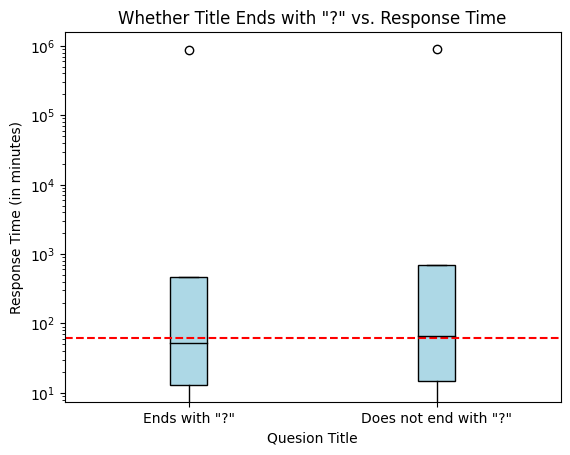

In [ ]:
  label = ['Ends with "?"', 'Does not end with "?"']
  plt.boxplot(question_mark.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels = label)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Quesion Title")
  plt.ylabel("Response Time (in minutes)")
  plt.title('Whether Title Ends with "?" vs. Response Time')
  plt.yscale("log")

We can see that questions that end with a question mark tend to be answered more quickly compared to those that do not end with a question mark. The trend indicates that proper punctuation might influence the promptness of receiving an answer.

### Question Length

Is a question with many words and information better than a short question with only the information that you think is useful? Use string function `LENGTH` to get the length of the question title and the question body in characters.

#### Title Length

In [ ]:
%%bigquery title_length --project $project_id

SELECT
  CONCAT(15*title_length, "-", 15*(title_length+1)-1) AS title_length_label,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    FLOOR(LENGTH(question_title) / 15) AS title_length,
    time_to_first_answer
  FROM
    `features_stackoverflow.avg_tag_popularity`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  title_length
ORDER BY
  title_length

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  title_length

,title_length_label,num_questions_answered,quantile_response_time
0,15-29,108591,"[0, 12, 45, 367, 866061]"
1,30-44,479620,"[0, 13, 51, 456, 870725]"
2,45-59,697372,"[0, 14, 59, 571, 891385]"
3,60-74,505345,"[0, 16, 68, 729, 899423]"
4,75-89,274060,"[0, 16, 78, 844, 900516]"
5,90-104,132186,"[0, 17, 84, 912, 904060]"
6,105-119,63159,"[0, 18, 88, 950, 901800]"
7,120-134,33182,"[0, 19, 98, 1200, 848360]"
8,135-149,23714,"[0, 18, 94, 1127, 834393]"
9,150-164,2124,"[0, 16, 78, 1005, 629846]"


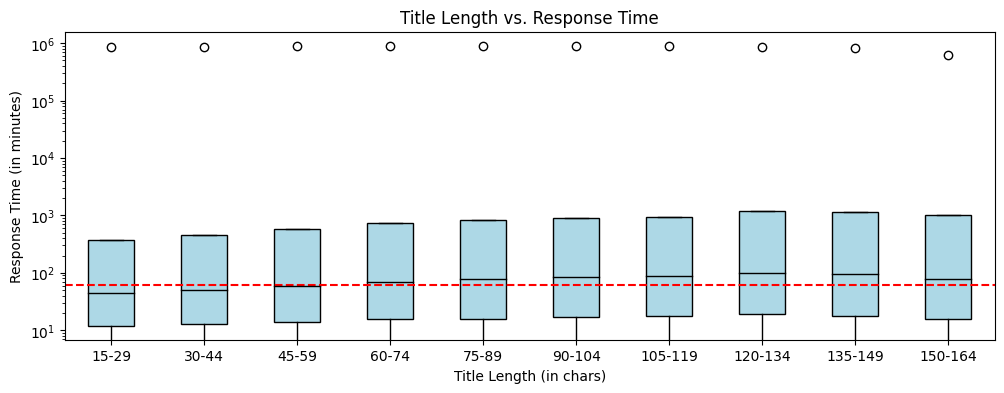

In [ ]:
  plt.figure(figsize = (12, 4))
  plt.boxplot(title_length.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=title_length.title_length_label)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Title Length (in chars)")
  plt.ylabel("Response Time (in minutes)")
  plt.title("Title Length vs. Response Time")
  plt.yscale("log")

#### Body Length

Remove HTML Tags from question body and calculate the body length.

In [ ]:
%%bigquery body_length --project $project_id

SELECT
  CONCAT("2^",log_body_length, "-", "2^",log_body_length+1) AS body_length_label,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    FLOOR(LOG(LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')), 2)) AS log_body_length,
    time_to_first_answer
  FROM
    `features_stackoverflow.avg_tag_popularity`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  log_body_length
ORDER BY
  log_body_length

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  body_length

,body_length_label,num_questions_answered,quantile_response_time
0,2^4-2^5,32,"[0, 11, 21, 200, 28984]"
1,2^5-2^6,1407,"[0, 8, 27, 209, 810392]"
2,2^6-2^7,19058,"[0, 9, 46, 508, 899423]"
3,2^7-2^8,126472,"[0, 10, 48, 584, 843787]"
4,2^8-2^9,382060,"[0, 10, 45, 498, 876123]"
5,2^9-2^10,661975,"[0, 12, 47, 449, 900516]"
6,2^10-2^11,625337,"[0, 16, 64, 575, 904060]"
7,2^11-2^12,336998,"[0, 23, 99, 977, 891385]"
8,2^12-2^13,120248,"[0, 29, 146, 1347, 890534]"
9,2^13-2^14,34919,"[0, 35, 189, 1603, 840319]"


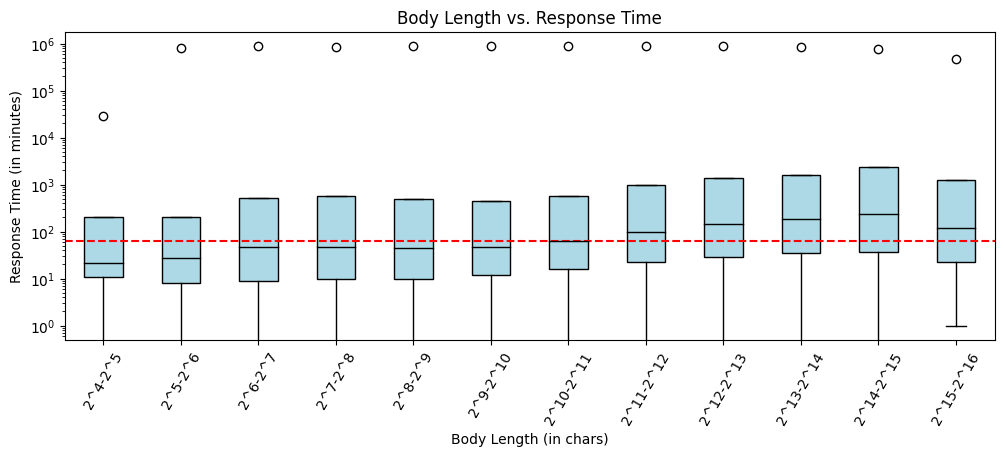

In [ ]:
  plt.figure(figsize = (12, 4))
  plt.boxplot(body_length.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=body_length.body_length_label)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Body Length (in chars)")
  plt.ylabel("Response Time (in minutes)")
  plt.title("Body Length vs. Response Time")
  plt.xticks(rotation = 60)
  plt.yscale("log")

We can see that as both the title length as well as body length increase, response time increases. In other words, succinct questions seem to receive faster responses. The trend indicates that conciseness in questions may positively affect the response time.

### Use of First-person Pronoun

First-person pronoun refers to the writer himself or herself using terms like "I," "me," or "we". The high frequency of first-person pronouns might indicate that the user has done certain amount of ground work before asking the question. Well-researched and thoughtfully presented questions are more likely to engage the community and receive timely responses.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `features_stackoverflow.first_person_pronoun` AS
WITH first_person_pronoun AS (
  SELECT
  question_id,
  COUNTIF(REGEXP_CONTAINS(LOWER(word), r'\b(?:i|mine|me|my|myself|we|us|our|ourselves)\b|\bi\'m\b|\bi\'ve\b|\bi\'ll\b|\bi\'d\b|\bwe\'re\b|\bwe\'ve\b|\bwe\'ll\b')) AS total_count,
  COUNT(*) AS num_word
FROM (
  SELECT
    question_id,
    word
  FROM
    `features_stackoverflow.avg_tag_popularity`,
    UNNEST(SPLIT(REGEXP_REPLACE(question_body, r'<[^>]+>', ''), ' ')) AS word )
GROUP BY
  question_id
)

SELECT
  questions.*,
  ROUND(100 * first_person_pronoun.total_count / first_person_pronoun.num_word, 2) AS frequency_first_person_pronoun
FROM
  `features_stackoverflow.avg_tag_popularity` questions
JOIN
  first_person_pronoun
ON
  questions.question_id = first_person_pronoun.question_id

Query is running:   0%|          |

""


In [ ]:
%%bigquery first_person_pronoun --project $project_id

SELECT
  CONCAT(0.5*frequency_first_person_pronoun, "-", 0.5*(frequency_first_person_pronoun+1)-0.01) AS frequency_first_person_pronoun_label,
  COUNT(*) AS num_questions_answered,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    time_to_first_answer,
    FLOOR(frequency_first_person_pronoun / 0.5) AS frequency_first_person_pronoun
  FROM
    `features_stackoverflow.first_person_pronoun`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  frequency_first_person_pronoun
ORDER BY
  frequency_first_person_pronoun
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
first_person_pronoun

,frequency_first_person_pronoun_label,num_questions_answered,quantile_response_time
0,0-0.49,167621,"[0, 15, 66, 667, 878580]"
1,0.5-0.99,191863,"[0, 17, 70, 659, 891385]"
2,1-1.49,200239,"[0, 16, 62, 565, 887946]"
3,1.5-1.99,187157,"[0, 15, 60, 584, 878921]"
4,2-2.49,174171,"[0, 15, 59, 529, 885710]"
5,2.5-2.99,162487,"[0, 14, 59, 549, 875091]"
6,3-3.49,148592,"[0, 14, 58, 588, 875257]"
7,3.5-3.99,133122,"[0, 14, 59, 605, 901800]"
8,4-4.49,128988,"[0, 14, 61, 605, 876123]"
9,4.5-4.99,109150,"[0, 14, 63, 672, 904060]"


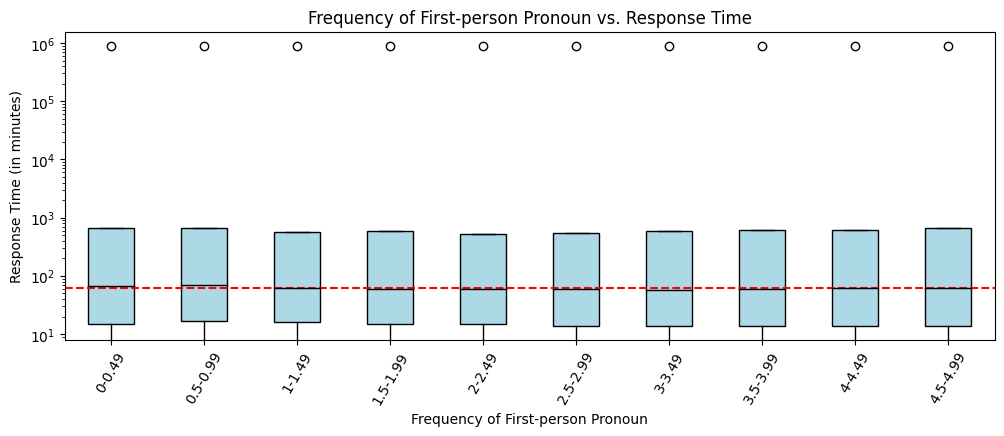

In [ ]:
  plt.figure(figsize = (12, 4))
  plt.boxplot(first_person_pronoun.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=first_person_pronoun.frequency_first_person_pronoun_label)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("Frequency of First-person Pronoun")
  plt.ylabel("Response Time (in minutes)")
  plt.title("Frequency of First-person Pronoun vs. Response Time")
  plt.xticks(rotation = 60)
  plt.yscale("log")

We can see  that response time slightly decreases as the frequency of first-person pronoun usage increases, although the decrease is not that significant. Therefore, these may provide weak evidence for estimating response time.

### User Tenure

We can also ask the data if veteran users get faster replies. This seems like a reasonable thing to happen since users who have been on StackOverflow longer would have higher reputation, but how true is it?

This query breaks down Stack Overflow users into different cohorts by the number of years they’ve been on the platform, and computes the approximate quantile boundaries for each cohort.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `features_stackoverflow.user_tenure` AS
SELECT
  *
FROM (
  SELECT
    questions.*,
    users.creation_date AS user_creation_date,
    ROUND(TIMESTAMP_DIFF(questions.question_creation_date, users.creation_date, DAY)/365) AS user_tenure
  FROM
    `features_stackoverflow.first_person_pronoun` questions
  LEFT JOIN
    `bigquery-public-data.stackoverflow.users` users
  ON
    questions.owner_user_id = users.id
)
WHERE
  user_tenure >= 0

Query is running:   0%|          |

""


In [ ]:
%%bigquery user_tenure --project $project_id

SELECT
  user_tenure,
  COUNT(*) AS number_of_questions,
  APPROX_QUANTILES(time_to_first_answer, 4) AS quantile_response_time
FROM (
  SELECT
    user_tenure,
    time_to_first_answer
  FROM
    `features_stackoverflow.user_tenure`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL))
GROUP BY
  user_tenure
ORDER BY
  user_tenure

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
  user_tenure

,user_tenure,number_of_questions,quantile_response_time
0,0.0,754174,"[0, 12, 46, 358, 887946]"
1,1.0,345808,"[0, 13, 48, 394, 904060]"
2,2.0,220028,"[0, 14, 58, 557, 885710]"
3,3.0,166160,"[0, 15, 68, 689, 866479]"
4,4.0,142660,"[0, 17, 75, 850, 900516]"
5,5.0,125103,"[0, 17, 83, 929, 891385]"
6,6.0,110661,"[0, 18, 95, 1048, 901800]"
7,7.0,102443,"[0, 20, 104, 1162, 883117]"
8,8.0,104952,"[0, 20, 110, 1181, 867787]"
9,9.0,95912,"[0, 21, 120, 1201, 872266]"


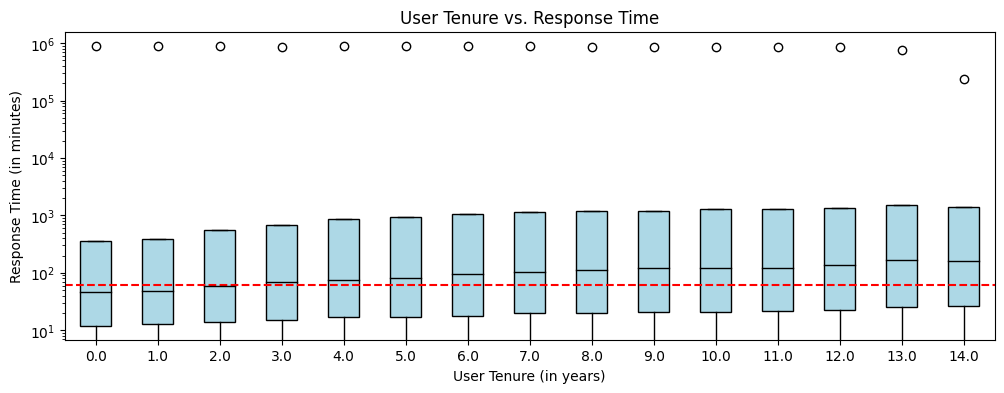

In [ ]:
  plt.figure(figsize = (12, 4))
  plt.boxplot(user_tenure.quantile_response_time, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"), medianprops = dict(color = "black"), labels=user_tenure.user_tenure)
  plt.axhline(y = 62, color = 'r', linestyle = 'dashed')
  plt.xlabel("User Tenure (in years)")
  plt.ylabel("Response Time (in minutes)")
  plt.title("User Tenure vs. Response Time")
  plt.yscale("log")

We can see that user tenure is positively correlated with response time. This may be attributed to the fact that user tenure is somewhat representative of the developer's experience level. Questions asked by beginners may be easier to answer while questions asked by experienced developers may be more complex and hence the response time of the question increases.

## Baseline and Data Prediction

Our goal in this section will be the following:

> *Given attributes about a question, predict if it will be answered in ≤ 62 minutes (median response time) or not.*

This is a *binary logistic regression task*, or classification task, where, given attributes about a question, we predict one of two labels: 1 = will be answered in ≤ 62 minutes; 0 = will not be answered in ≤ 62 minutes.

Once we've trained our model, we can then use it to make predictions on data not used for training.

### Query vs ML Solution Cost Analysis

#### KNN Baseline

In [ ]:
  dataset_name = 'knn_stackoverflow'

  dataset = bigquery.Dataset(client.dataset(dataset_name))
  dataset.location = 'US'
  client.create_dataset(dataset)

Separate the data into training dataset, validation dataset and test dataset.

The evaluation (validation and test) dataset is too large for the KNN. It requires outputting a lot of data in an intermediate step and exceeds the ratio supported by the on-demand pricing model. So I reduced the size of evaluation datasets to 3000 rows and used the same smaller validation set for both the KNN and ML model to compare performance in a chosen metric. In the final analysis of the ML model, I used the larger evaluation set for measuring how the logistic regression model is.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `knn_stackoverflow.train` AS
SELECT
  IF(time_to_first_answer BETWEEN 0 AND 62, 1, 0) AS label,
  question_id,
  EXTRACT(DAYOFWEEK FROM question_creation_date) AS question_day,
  EXTRACT(HOUR FROM question_creation_date) AS question_hour,
  num_tags,
  avg_tag_popularity,
  IF(LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%', 1, 0) AS question_word,
  IF(question_title LIKE '%?', 1, 0) AS question_mark,
  LENGTH(question_title) AS title_length,
  LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')) AS body_length,
  frequency_first_person_pronoun,
  user_tenure
FROM
  `features_stackoverflow.user_tenure`
WHERE
  EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
  AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `knn_stackoverflow.validation` AS
WITH validation AS (
  SELECT
    question_id,
    EXTRACT(DAYOFWEEK FROM question_creation_date) AS question_day,
    EXTRACT(HOUR FROM question_creation_date) AS question_hour,
    num_tags,
    avg_tag_popularity,
    IF(LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%', 1, 0) AS question_word,
    IF(question_title LIKE '%?', 1, 0) AS question_mark,
    LENGTH(question_title) AS title_length,
    LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')) AS body_length,
    frequency_first_person_pronoun,
    user_tenure,
    IF(time_to_first_answer BETWEEN 0 AND 62, 1, 0) AS label
  FROM
    `features_stackoverflow.user_tenure`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2022-06-01' AND '2022-07-31'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)
)

SELECT
  *
FROM
  validation
WHERE
  RAND() < (3000 / (SELECT COUNT(*) FROM validation))
LIMIT
  3000

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `knn_stackoverflow.test` AS
WITH test AS (
  SELECT
    question_id,
    EXTRACT(DAYOFWEEK FROM question_creation_date) AS question_day,
    EXTRACT(HOUR FROM question_creation_date) AS question_hour,
    num_tags,
    avg_tag_popularity,
    IF(LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%', 1, 0) AS question_word,
    IF(question_title LIKE '%?', 1, 0) AS question_mark,
    LENGTH(question_title) AS title_length,
    LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')) AS body_length,
    frequency_first_person_pronoun,
    user_tenure,
    IF(time_to_first_answer BETWEEN 0 AND 62, 1, 0) AS label
  FROM
    `features_stackoverflow.user_tenure`
  WHERE
    EXTRACT(DATE FROM question_creation_date) BETWEEN '2022-08-01' AND '2022-09-15'
    AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)
)

SELECT
  *
FROM
  test
WHERE
  RAND() < (3000 / (SELECT COUNT(*) FROM test))
LIMIT
  3000


Query is running:   0%|          |

""


Set the value of k in KNN = sqrt(n). where n = number of data points in training data.

k = sqrt(2319340) = 1523

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `knn_stackoverflow.validation_prediction` AS
WITH distance_calc AS (
  SELECT
    validation.question_id AS validation_question_id,
    validation.label AS validation_label,
    train.question_id AS train_question_id,
    train.label AS  trian_label,
    SQRT(
      POWER(validation.question_day - train.question_day, 2) +
      POWER(validation.question_hour - train.question_hour, 2) +
      POWER(validation.num_tags - train.num_tags, 2) +
      POWER(validation.avg_tag_popularity - train.avg_tag_popularity, 2) +
      POWER(validation.question_word - train.question_word, 2) +
      POWER(validation.question_mark - train.question_mark, 2) +
      POWER(validation.title_length - train.title_length, 2) +
      POWER(validation.body_length - train.body_length, 2) +
      POWER(validation.user_tenure - train.user_tenure, 2) +
      POWER(validation.frequency_first_person_pronoun - train.frequency_first_person_pronoun, 2)
    ) AS distance
  FROM
    `knn_stackoverflow.validation` validation
  CROSS JOIN
    `knn_stackoverflow.train` train
),
top_k_neighbors AS (
  SELECT
    *
  FROM (
    SELECT
      *,
      RANK() OVER (PARTITION BY validation_question_id ORDER BY distance) AS distance_rank
    FROM
      distance_calc
  )
  WHERE
    distance_rank <= 1523
),
category_frequency AS (
  SELECT
    validation_question_id,
    validation_label,
    trian_label,
    COUNT(*) AS frequency
  FROM
    top_k_neighbors
  GROUP bY
    validation_question_id, validation_label, trian_label
),
ranked_category_frequency AS (
  SELECT
    validation_question_id,
    validation_label,
    trian_label,
    RANK() OVER (PARTITION BY validation_question_id ORDER BY frequency DESC) AS frequency_rank
  FROM
    category_frequency
)

SELECT
  validation_question_id,
  validation_label,
  trian_label AS predicted_label
FROM
  ranked_category_frequency
WHERE
  frequency_rank = 1

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

SELECT
  COUNTIF(validation_label = predicted_label) / COUNT(*) AS accuracy
FROM
  `knn_stackoverflow.validation_prediction`

Query is running:   0%|          |

Downloading:   0%|          |

,accuracy
0,0.711333


Evaluate the final model on the test set.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `knn_stackoverflow.test_prediction` AS
WITH distance_calc AS (
  SELECT
    test.question_id AS test_question_id,
    test.label AS test_label,
    train.question_id AS train_question_id,
    train.label AS  trian_label,
    SQRT(
      POWER(test.question_day - train.question_day, 2) +
      POWER(test.question_hour - train.question_hour, 2) +
      POWER(test.num_tags - train.num_tags, 2) +
      POWER(test.avg_tag_popularity - train.avg_tag_popularity, 2) +
      POWER(test.question_word - train.question_word, 2) +
      POWER(test.question_mark - train.question_mark, 2) +
      POWER(test.title_length - train.title_length, 2) +
      POWER(test.body_length - train.body_length, 2) +
      POWER(test.user_tenure - train.user_tenure, 2) +
      POWER(test.frequency_first_person_pronoun - train.frequency_first_person_pronoun, 2)
    ) AS distance
  FROM
    `knn_stackoverflow.test` test
  CROSS JOIN
    `knn_stackoverflow.train` train
),
top_k_neighbors AS (
  SELECT
    *
  FROM (
    SELECT
      *,
      RANK() OVER (PARTITION BY test_question_id ORDER BY distance) AS distance_rank
    FROM
      distance_calc
  )
  WHERE
    distance_rank <= 1523
),
category_frequency AS (
  SELECT
    test_question_id,
    test_label,
    trian_label,
    COUNT(*) AS frequency
  FROM
    top_k_neighbors
  GROUP bY
    test_question_id, test_label, trian_label
),
ranked_category_frequency AS (
  SELECT
    test_question_id,
    test_label,
    trian_label,
    RANK() OVER (PARTITION BY test_question_id ORDER BY frequency DESC) AS frequency_rank
  FROM
    category_frequency
)

SELECT
  test_question_id,
  test_label,
  trian_label AS predicted_label
FROM
  ranked_category_frequency
WHERE
  frequency_rank = 1

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

SELECT
  COUNTIF(test_label = predicted_label) / COUNT(*) AS accuracy
FROM
  `knn_stackoverflow.test_prediction`

Query is running:   0%|          |

Downloading:   0%|          |

,accuracy
0,0.71


#### Logistic Regression

In [ ]:
model_dataset_name = 'bqml_stackoverflow'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_stackoverflow.stackoverflow_model` -- we'll call our model 'stackoverflow_model'
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(time_to_first_answer BETWEEN 0 AND 62, 1, 0) AS label,
  EXTRACT(DAYOFWEEK FROM question_creation_date) AS question_day,
  EXTRACT(HOUR FROM question_creation_date) AS question_hour,
  num_tags,
  avg_tag_popularity,
  IF(LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%', 1, 0) AS question_word,
  IF(question_title LIKE '%?', 1, 0) AS question_mark,
  LENGTH(question_title) AS title_length,
  LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')) AS body_length,
  frequency_first_person_pronoun,
  user_tenure
FROM
  `features_stackoverflow.user_tenure`
WHERE
  EXTRACT(DATE FROM question_creation_date) BETWEEN '2021-01-01' AND '2022-05-31'
  AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_stackoverflow.stackoverflow_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.619125,0.621007,6.4,10368
1,0,4,0.620547,0.622173,3.2,9984
2,0,3,0.632605,0.633718,1.6,9158
3,0,2,0.653717,0.654367,0.8,8779
4,0,1,0.672911,0.673228,0.4,9948
5,0,0,0.685746,0.685860,0.2,7659


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.stackoverflow_model`, (
SELECT
  label,
  question_day,
  question_hour,
  num_tags,
  avg_tag_popularity,
  question_word,
  question_mark,
  title_length,
  body_length,
  frequency_first_person_pronoun,
  user_tenure,
FROM
  `knn_stackoverflow.validation`))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.541033,0.194962,0.704667,0.286634,0.591254,0.646497


#### Analysis

**Performance in Chosen Metric**

- KNN: With an accuracy of 0.71, KNN is performing slightly better than the ML solution.
- ML Solution: With an accuracy of 0.70, the logistic regression model is slightly less accurate.

**Time/Cost to Process Data and Train**

- KNN: The query executed in 48.993s. It has no training stage (besides storing/processing the training data), but the prediction stage can be very time-consuming as it requires computing the distance from each validation point to all training points. The complexity is O(n) for each prediction, where n is the number of training points.

- ML Solution: ML models require time for training (80.309s). Training a regression model has a time complexity of O(mn^2) for m features and n training points using normal equations, or O(kmn) for k iterations of gradient descent. Once trained, predictions are very fast (2.464s), with complexity O(m).

**IO Cost**

Assume all the following hardware information:
We have access to 500 buffer pages where each page is 10MB
Reading each page costs 1IO and writing costs 10IO.
1KB = 1000bytes, 1MB = 1000KB, 1GB = 1000MB, etc.

The validation table is 281.25KB and the train table is 212.34 MB. They are not sorted and not hashed. There are 3,000 rows in the validation table and 2,319,340 rows in the train table. There are no null values in validation or train table.

- KNN:

  We use a cross join to combine all rows of validation table with all rows of train table, which allows us to compare every test point against every training point. Assuming that there are 3 possible join algorithms (HPJ, SMJ, BNLJ). We know that BNLJ is the most optimal of the 3 joins if one of the tables fits in RAM.  Since the validation table is much smaller than the RAM size, we can load it entirely into the RAM. In that case, we only need to compute the number of IOs for the KNN query using BNLJ and don't need to numerically compute the IOs for the other two algorithms since we know it'll be worse.

  Assume the size of each row in each output table is 1KB.

  Define the output of BNLJ(validation, train) as VTJ.

  VTJ_num_rows = validation_row_size * train_row_size = 3000 * 2319340 = 6,958,020,000

  VTJ_size = VTJ_row_size * VTJ_num_rows = 1 KB * 6,958,020,000 = 6,958,020 MB

  VTJ_num_pages = VTJ_size / page_size = 6,958,020 MB / 10MB =  695,802

  P(validation) = validation_num_pages = validation_size / page_size = 281.25KB / 10MB = 1

  P(train) = train_num_pages = train_size / page_size = 212.34 MB / 10MB = 22

  OUT = VTJ_num_pages = 695,802

  B = 500, C_r = 1IO, C_w = 10IO

  BNLJ(validation, train) = C_r * (P(validation) + P(train)) + C_w * OUT = 1 * (1 + 22) + 10 * 695,802 = 6,958,043IO

  After the cross join, we can then calculate distances for each pairing. After calculating the distances, we can ORDER BY the distance in ascneding order for each point by BigSort(VTJ).

  BigSort(VTJ) = 3000 * ((1 + 10) * (2319340 * 1 KB / 10 MB) * 1) = 7,653,822IO

  After sorting by distance, we can use a LIMIT clause to select the top K (K = 1523) entries with the smallest distance. Let's define the output as VTJSK.

  VTJSK_num_rows = validation_row_size * k = 3000 * 1523 = 4,569,000

  VTJSK_size = 4,569,000 * 1KB = 4569MB

  VTJSK_num_pages = VTJSK_size / page_size = 4569MB/10MB = 457

  Then grouping the selected K nearest neighbours by their label and counting the frequency of each label. Finally, we select the label with the highest count as the prediction.

  OUT = P(validation) = 1

  KNN(VTJSK) = C_r * VTJSK_num_pages + C_w * OUT = 1 * 457 +10 * 1 = 467IO

  Total IO Cost = BNLJ(validation, train) + BigSort(VTJ) + KNN(VTJSK) = 6,958,043 + 7,653,822 + 467 = 14,612,332 IO

- ML Solution:
  
  Assume all the following information:

  - Logistic regression performs all the computations in memory and only reads data from disk without writing any data back to disk.
  - Set the number of iterations to 6. The training table is read entirely for each iteration.
  - Validation is done after training, reading the entire validation table.

  Total IO Cost = C_r * (P(train) * 6 + P(validation)) = 1.0 * (22 * 6 + 1) = 133 IO

**Monetary Cost**

- KNN: The amount of data scanned for each query can be found on the GCP BigQuery Console at the top right corner of the screen. With the on-demand pricing model, we are charged \$5 per TB of data scanned by each query. This query will process 194.92MB when run and cost around \$0.001.

- ML Solution:

  Logistic regression requires multiple passes over the data for iterations. Each pass involves computational resources, leading to monetary cost for data processing.

  Computational Cost  = \$0.001 * 133 IO / 14,612,332 IO = \$0.000000009

  Intermediate results, models, and final results need to be stored. This incurs storage costs, especially if the dataset is large.

  If data is transferred between different storage locations, there are additional data transfer costs.

  The complexity of the logistic regression model (like the number of features) can also impact IO costs. More complex models may require more computational resources.

**10M Data Points**

- KNN: Would be computationally expensive due to the need to compute distances to all 10M points for each prediction. The IO cost would also be significant as each query would require scanning the entire dataset.

- ML Solution: Training would be resource-intensive, but after training, the model would make predictions quickly and with less IO cost.

**1B Data Points**

- KNN: May become impractical due to complex joins or calculations, leading to excessive computation and IO costs.

- ML Solution: Might still be feasible, especially with incremental learning, but the training and inference would likely need to be distributed across multiple machines or even clusters, increasing the cost.

**What are tradeoffs between these decisions based on the amount of data?**

- KNN has almost no training time. Database solutions might be cheaper and faster for small to medium datasets, especially if the operations are simple. However, as the complexity of the operations and the size of the data increase, performance might degrade rapidly, leading to high costs in terms of both time and resources.

- ML models have a significant upfront training time but then make predictions quickly. As the amount of data increases, the time and cost to train an ML model will increase, but the model's accuracy might also improve.

- KNN does not scale well with the number of data points, whereas ML models can be trained on a subset and still generalize well.

**Why do tradeoffs exist?**
- ML models, once trained, can make predictions quickly without needing to scan through the entire dataset each time, which is what might happen with complex DB queries on large datasets.
- Database queries do not improve in performance with more data; they just become slower unless optimized with indices, which themselves have a storage cost and maintenance overhead.
- ML solutions can scale horizontally (across more machines), often more easily than database solutions, which may require vertical scaling (more powerful machines) due to limitations in database architecture or the need for complex joins.

While KNN is performing slightly better in terms of the chosen metric, it may not be the most efficient choice as the amount of data grows due to its prediction time and IO costs. The decision between the two methods would depend on the specific context, such as the dataset size, the acceptable latency, the available computational resources, and the cost constraints.

### Data Prediction

Evaluate the model on the larger evaluation set.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.stackoverflow_model`, (
SELECT
  IF(time_to_first_answer BETWEEN 0 AND 62, 1, 0) AS label,
  EXTRACT(DAYOFWEEK FROM question_creation_date) AS question_day,
  EXTRACT(HOUR FROM question_creation_date) AS question_hour,
  num_tags,
  avg_tag_popularity,
  IF(LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%', 1, 0) AS question_word,
  IF(question_title LIKE '%?', 1, 0) AS question_mark,
  LENGTH(question_title) AS title_length,
  LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')) AS body_length,
  frequency_first_person_pronoun,
  user_tenure
FROM
  `features_stackoverflow.user_tenure`
WHERE
  EXTRACT(DATE FROM question_creation_date) BETWEEN '2022-06-01' AND '2022-07-31'
  AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.521392,0.187186,0.701805,0.275474,0.591298,0.648825


Evaluate the final model on the test set.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.stackoverflow_model`, (
SELECT
  IF(time_to_first_answer BETWEEN 0 AND 62, 1, 0) AS label,
  EXTRACT(DAYOFWEEK FROM question_creation_date) AS question_day,
  EXTRACT(HOUR FROM question_creation_date) AS question_hour,
  num_tags,
  avg_tag_popularity,
  IF(LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%', 1, 0) AS question_word,
  IF(question_title LIKE '%?', 1, 0) AS question_mark,
  LENGTH(question_title) AS title_length,
  LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')) AS body_length,
  frequency_first_person_pronoun,
  user_tenure
FROM
  `features_stackoverflow.user_tenure`
WHERE
  EXTRACT(DATE FROM question_creation_date) BETWEEN '2022-08-01' AND '2022-09-15'
  AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.508908,0.185079,0.706812,0.271441,0.588611,0.643741


The performance of the logistic regression model can be assessed based on the provided metrics:

- **Precision (0.51)**: The model's precision is around 50%, meaning that when it predicts a positive outcome (a question will be answered in ≤ 62 minutes), it is correct about half of the time.

- **Recall (0.19)**: The recall is low, indicating that the model identifies less than 19% of all actual positive cases.

- **Accuracy (0.71)**: Despite the relatively low precision and recall, the accuracy is about 71%, which could suggest that the model is better at predicting the negative class or that the dataset might be imbalanced with more negative instances.

- **F1 Score (0.27)**: This is relatively low, showing that the model has room for improvement in terms of precision and recall balance.

- **Log Loss (0.59)**: A lower log loss indicates better performance. A log loss of approximately 0.59 indicates a moderate level of uncertainty in the predictions.

- **ROC AUC (0.64)**: This metric shows the ability of the model to distinguish between classes. A score of 0.64 is better than random guessing, indicating a moderate ability to differentiate between the classes.

Based on these metrics, the model has a relatively high accuracy but is more conservative in predicting the positive class. The moderate F1 score and ROC AUC score suggest that there is a potential to improve the model's performance, possibly by feature engineering, model tuning, or considering a different algorithm that may capture the complexity of the data better.

Use the trained model to predict on questions that posted between 2022-09-16 and 2022-09-30.

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT
  predicted_label
FROM
  ML.PREDICT(MODEL `bqml_stackoverflow.stackoverflow_model`, (
SELECT
  EXTRACT(DAYOFWEEK FROM question_creation_date) AS question_day,
  EXTRACT(HOUR FROM question_creation_date) AS question_hour,
  num_tags,
  avg_tag_popularity,
  IF(LOWER(question_title) LIKE 'wh%' OR LOWER(question_title) LIKE 'how%', 1, 0) AS question_word,
  IF(question_title LIKE '%?', 1, 0) AS question_mark,
  LENGTH(question_title) AS title_length,
  LENGTH(REGEXP_REPLACE(question_body, r'<[^>]+>', '')) AS body_length,
  frequency_first_person_pronoun,
  user_tenure
FROM
  `features_stackoverflow.user_tenure`
WHERE
  EXTRACT(DATE FROM question_creation_date) BETWEEN '2022-09-16' AND '2022-09-30'
  AND (time_to_first_answer >= 0  OR time_to_first_answer IS NULL)))

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_label
0,0
1,0
2,0
3,0
4,0
...,...
47222,1
47223,0
47224,1
47225,0


## Conclusion

Stack Overflow is the largest online community for programmers to learn, share their knowledge, and advance their careers, but after posting a question, he/she has to wait till someone responds. So it will be very helpful if we predict the response time before actually putting the question.

We construct and study some potentially indicative features in estimating the response time of questions.

- **Post Date**: The time when the question is posted can impact response time. Posting during peak hours when more users are online can lead to quicker responses.

- **Tags**: Using one or two popular tags in a question is likely to result in an earlier answer on average.

- **Title**: Using question words such as "why", "what" and "how" to clearly stated questions with sufficient details and adding a “?” at the end of the title can lead to quicker responses.

- **Question Length**: Succinct questions are likely to receive faster responses.

- **Use of First-person Pronoun**: Using first-person pronouns shows that you have been well researched and thought through and is likely to receive a faster response.

- **User Tenure**: New users are likely to receive faster responses.

Understanding these factors can help in strategizing the posting of questions for quicker and more effective responses. If I had more time time, I would explore new feature such as the number of code segments and total code length in the question.

Based on the explorations and analysis, I train a parametric prediction model (logistic regression) using BigQuery. the model has a relatively high accuracy but is more conservative in predicting the positive class. The moderate F1 score and ROC AUC score suggest that there is a potential to improve the model's performance, possibly by feature engineering or model tuning.